# Coagulation Patterns: Comparison of Number and Mass

In this notebook, we explore and compare three distinct methods for representing particle distributions and modeling the coagulation process: the probability mass function (PMF), the probability density function (PDF), and the particle-resolved approach. The goal is to evaluate how each method impacts the number and mass of particles as coagulation progresses, providing insight into their strengths and limitations.


**Imports**

<details> <summary>▶️ Install Particula</summary>
try:
    import google.colab
except ImportError:
    # not Colab → do nothing
    pass
else:
    # in Colab → install quietly
    get_ipython().system("pip install particula[extra] --quiet")
</details>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import particula as par

## Setup Distributions

In this section, we define the common parameters used throughout the notebook for modeling the particle distribution and atmosphere. These parameters include the mode of the particle size distribution, the geometric standard deviation, the number of particles in each mode, and the particle density. Additionally, we set the volume of the system for our simulations. The volume is only needed for the particle resolved approach, as the PMF and PDF methods do not require a volume to be defined.

We also construct a simplified atmospheric environment using an `AtmosphereBuilder`, which includes a preset gas species that does not condense in the atmosphere. The temperature is set to 25°C and the pressure to 1 atmosphere, reflecting typical ambient conditions.

In [2]:
# common parameters
mode = np.array([100e-9, 300e-9])  # m
geometric_standard_deviation = np.array([1.3, 1.3])
number_of_particles = np.array(
    [0.75, 0.25]
)  # effective when pdf has multiple modes
density = np.array([1.0e3])
volume = 1 * par.util.get_unit_conversion("cm^3", "m^3")  # cm^-3 to m^-3

# Preset gas species that does not condense in the atmosphere
# AtmosphereBuilder constructs the atmosphere with predefined species
atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_temperature(25, temperature_units="degC")  # Set temperature to 25°C
    .set_pressure(1, pressure_units="atm")  # Set pressure to 1 atmosphere
    .build()  # Finalize the atmosphere object
)

**Particle Resolved**

In this section, we generate a particle distribution using a lognormal sample distribution, which is characterized by a specified mode (mean particle diameter) and geometric standard deviation (GSD). We then calculate the mass of each particle, assuming a constant density.

Following this, we create a resolved mass representation for each particle, which defines how properties like mass, activity, and particle surfaces represented. The resolved mass representation is built using predefined strategies for mass distribution, activity, and surface area. We assign particle mass, set density, assume neutral particles (with no charge), and define the volume of the distribution.

Finally, we combine the resolved particle properties with the atmospheric conditions to create an `Aerosol` object, which encapsulates both the particles and the atmosphere. The aerosol properties are then printed to provide an overview of the system.


In [3]:
number_of_samples = 100_000  # Number of samples for particle distribution

# Generate a particle distribution using a lognormal sample distribution
# This distribution has a mean particle diameter (mode) and geometric standard deviation (GSD)
radii_sample = par.particles.get_lognormal_sample_distribution(
    mode=mode,
    geometric_standard_deviation=geometric_standard_deviation,
    number_of_particles=number_of_particles,
    number_of_samples=number_of_samples,  # Number of samples for particle distribution
)

# Calculate the mass of each particle in the sample, assuming density of 1500 kg/m^3
particle_mass_sample = (
    4 / 3 * np.pi * radii_sample**3 * density
)  # Particle mass in kg

print(f"Total mass of particles: {np.sum(particle_mass_sample):.2e} kg")
# Build a resolved mass representation for each particle
# This defines how particle mass, activity, and surface are represented
resolved_masses = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    # Use specieated mass distribution, ideal mass activity, and volume surface strategy
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(par.particles.ActivityIdealMass())
    .set_surface_strategy(par.particles.SurfaceStrategyVolume())
    .set_mass(particle_mass_sample, "kg")  # Assign mass of particles (in kg)
    .set_density(density, "kg/m^3")  # Set particle density
    .set_charge(0)  # Assume neutral particles with no charge
    .set_volume(volume, "m^3")  # Set volume of particle distribution
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol_resolved = par.Aerosol(
    atmosphere=atmosphere, particles=resolved_masses
)

# Print the properties of the aerosol
print(aerosol_resolved)

Total mass of particles: 4.29e-12 kg
Gas mixture at 298.15 K, 101325.0 Pa, partitioning=None, gas_only_species=None
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 4.287e-06 [kg/m^3]
	Number Concentration: 1.000e+11 [#/m^3]


**PMF**

Here, we generate a Probability Mass Function (PMF) approach. We define the radius bins using a logarithmic scale and calculate the number concentration of particles based on the total number of particles and the system volume. The PMF distribution is then built by specifying the particle mode, geometric standard deviation, and number concentration.

We set the distribution type to 'PMF' and define the radius bins, which represent the particle size categories. The particle density is also specified, and the PMF-based particle representation is finalized.

After setting up the PMF particle distribution, we create an aerosol object that combines the PMF particle properties with the previously defined atmospheric conditions. The properties of the aerosol object are printed to give a summary of the system configuration.

In [4]:
radius_bins = np.logspace(
    -8, -6, 250
)  # Define the radius bins for the resolved mass representation

number_concentration = number_of_particles * np.array(
    [number_of_samples / volume]
)  # Calculate the number concentration of particles
print(f"Number concentration: {number_concentration[0]:.2e} m^-3")
particle_pmf = (
    par.particles.PresetParticleRadiusBuilder()
    .set_mode(mode, mode_units="m")  # Set the mode of the distribution
    .set_geometric_standard_deviation(geometric_standard_deviation)
    .set_number_concentration(
        number_concentration, "m^-3"
    )  # Set the number concentration
    .set_distribution_type("pmf")  # Set the distribution type to PMF
    .set_radius_bins(radius_bins, radius_bins_units="m")  # Set the radius bins
    .set_density(density, "kg/m^3")  # Set particle density
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol_pmf = par.Aerosol(atmosphere=atmosphere, particles=particle_pmf)

# Print the properties of the aerosol
print(aerosol_pmf)

Number concentration: 7.50e+10 m^-3
Gas mixture at 298.15 K, 101325.0 Pa, partitioning=None, gas_only_species=None
Particle Representation:
	Strategy: RadiiBasedMovingBin
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 4.282e-06 [kg/m^3]
	Number Concentration: 1.000e+11 [#/m^3]


**PDF**

Lastly, we generate a particle distribution using the Probability Density Function (PDF) approach. Similar to the PMF setup, we specify the particle mode, geometric standard deviation, and number concentration. However, in this case, the distribution type is set to "PDF", which models the particle distribution as a continuous probability density function over the defined radius bins.

We assign the same logarithmic radius bins as before, specify the particle density, and assume the particles are neutral by setting their charge to zero. After defining all necessary parameters, we finalize the PDF-based particle representation.

As with the PMF approach, we create an aerosol object by combining the PDF-based particle distribution with the predefined atmospheric conditions. The properties of the resulting aerosol are printed to summarize the system configuration.


In [5]:
particle_pdf = (
    par.particles.PresetParticleRadiusBuilder()
    .set_mode(mode, mode_units="m")  # Set the mode of the distribution
    .set_geometric_standard_deviation(geometric_standard_deviation)
    .set_number_concentration(
        number_concentration, "m^-3"
    )  # Set the number concentration
    .set_distribution_type("pdf")  # Set the distribution type to PMF
    .set_radius_bins(radius_bins, radius_bins_units="m")  # Set the radius bins
    .set_density(density, "kg/m^3")  # Set particle density
    .set_charge(
        np.zeros_like(radius_bins)
    )  # Assume neutral particles with no charge
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol_pdf = par.Aerosol(atmosphere=atmosphere, particles=particle_pdf)

# Print the properties of the aerosol
print(aerosol_pdf)

Gas mixture at 298.15 K, 101325.0 Pa, partitioning=None, gas_only_species=None
Particle Representation:
	Strategy: RadiiBasedMovingBin
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 7.797e+02 [kg/m^3]
	Number Concentration: 4.663e+19 [#/m^3]


**Plot Initial Distributions**

In this section, we plot the initial particle distributions for the PMF, and particle-resolved approaches. The plots show the number concentration of particles as a function of particle radius for each method. The PMF is a line, and the particle-resolved has been binned into discrete sizes.

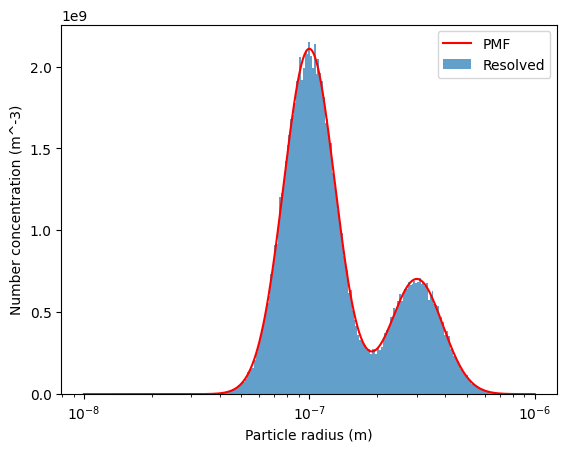

In [6]:
# plot both
radius_bins = particle_pmf.get_radius()
radii_resolved = resolved_masses.get_radius()

fig, ax = plt.subplots()
bins, edges = np.histogram(radii_resolved, bins=radius_bins)
ax.bar(
    edges[:-1],
    bins / volume,
    width=np.diff(edges),
    align="edge",
    label="Resolved",
    alpha=0.7,
)
ax.plot(
    radius_bins,
    particle_pmf.get_concentration(),
    label="PMF",
    color="red",
)
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Number concentration (m^-3)")
ax.legend()
plt.show()

## Simulate Coagulation

In this section, we simulate the coagulation process for the PMF, PDF, and particle-resolved approaches. We define the time step for the simulation and the total simulation time. The time step is used to update the particle distribution at regular intervals, while the total simulation time determines the duration of the coagulation process.

In [7]:
# simulate aerosols, and save total mass and number distribution

# Define the coagulation process
coagulation_process_pmf = par.dynamics.Coagulation(
    coagulation_strategy=par.dynamics.BrownianCoagulationStrategy(
        distribution_type="discrete"
    )
)

coagulation_process_resolved = par.dynamics.Coagulation(
    coagulation_strategy=par.dynamics.BrownianCoagulationStrategy(
        distribution_type="particle_resolved"
    )
)
coagulation_process_pdf = par.dynamics.Coagulation(
    coagulation_strategy=par.dynamics.BrownianCoagulationStrategy(
        distribution_type="continuous_pdf"
    )
)

# Set up time and sub-steps for the coagulation process
total_time = 10000
time_step = 100
sub_steps = 1

# output arrays
time = np.arange(0, total_time, time_step)
total_mass_pmf = np.zeros_like(time, dtype=np.float64)
total_mass_resolved = np.ones_like(time, dtype=np.float64)
total_mass_pdf = np.zeros_like(time, dtype=np.float64)
number_distribution_pmf = np.zeros((len(time), len(radius_bins)))
number_distribution_resolved = np.zeros((len(time), number_of_samples))
number_distribution_pdf = np.zeros((len(time), len(radius_bins)))
total_number_pmf = np.zeros_like(time, dtype=np.float64)
total_number_resolved = np.ones_like(time, dtype=np.float64)
total_number_pdf = np.zeros_like(time, dtype=np.float64)

**Simulation Loop**

We then run a simulation loop that iterates over the specified time range, updating the particle distribution at each time step.

In [10]:
# Simulation loop

for i, t in enumerate(time):
    if i > 0:
        # Perform coagulation for the PDF aerosol
        aerosol_pdf = coagulation_process_pdf.execute(
            aerosol_pdf, time_step, sub_steps
        )
        # Perform coagulation for the PMF aerosol
        aerosol_pmf = coagulation_process_pmf.execute(
            aerosol_pmf, time_step, sub_steps
        )
        # Perform coagulation for the resolved aerosol
        aerosol_resolved = coagulation_process_resolved.execute(
            aerosol_resolved, time_step, sub_steps
        )

    total_mass_resolved[i] = aerosol_resolved.particles.get_mass_concentration()
    number_distribution_resolved[i, :] = aerosol_resolved.particles.get_radius(clone=True)
    total_number_resolved[i] = np.sum(number_distribution_resolved[i, :] > 0)

    total_mass_pmf[i] = aerosol_pmf.particles.get_mass_concentration()
    number_distribution_pmf[i, :] = aerosol_pmf.particles.get_concentration(
        clone=True
    )
    total_number_pmf[i] = np.sum(number_distribution_pmf[i, :])

    total_mass_pdf[i] = aerosol_pdf.particles.get_mass_concentration()
    number_distribution_pdf[i, :] = aerosol_pdf.particles.get_concentration(
        clone=True
    )
    total_number_pdf[i] = np.trapezoid(
        number_distribution_pdf[i, :], radius_bins
    )

## Results

The results of the coagulation simulations are presented in this section. We compare the number and mass of particles for the PMF, PDF, and particle-resolved approaches at different time points during the coagulation process.

The fist thing to check is the final state of the aerosol system.


In [11]:
print(aerosol_resolved)
print(aerosol_pmf)
# print(aerosol_pdf)

Gas mixture at 298.15 K, 101325.0 Pa, partitioning=None, gas_only_species=None
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 4.286e-06 [kg/m^3]
	Number Concentration: 6.263e+10 [#/m^3]
Gas mixture at 298.15 K, 101325.0 Pa, partitioning=None, gas_only_species=None
Particle Representation:
	Strategy: RadiiBasedMovingBin
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 4.242e-06 [kg/m^3]
	Number Concentration: 6.259e+10 [#/m^3]


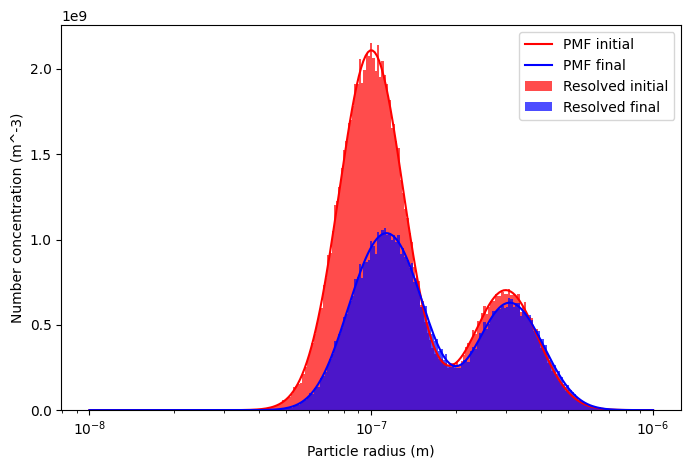

In [12]:
# plot the initial and final distributions
fig, ax = plt.subplots(figsize=(8, 5))

bins, edges = np.histogram(
    number_distribution_resolved[0, :], bins=radius_bins
)
ax.bar(
    edges[:-1],
    bins / volume,
    width=np.diff(edges),
    align="edge",
    label="Resolved initial",
    color="red",
    alpha=0.7,
)
bins, edges = np.histogram(
    number_distribution_resolved[-1, :], bins=radius_bins
)
ax.bar(
    edges[:-1],
    bins / volume,
    width=np.diff(edges),
    align="edge",
    label="Resolved final",
    color="blue",
    alpha=0.7,
)

ax.plot(
    radius_bins,
    number_distribution_pmf[0, :],
    label="PMF initial",
    color="red",
)
ax.plot(
    radius_bins,
    number_distribution_pmf[-1, :],
    label="PMF final",
    color="blue",
)

ax.set_xscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Number concentration (m^-3)")
ax.legend()
plt.show()

**Plot Mass Conservation**

In and ideal system, the mass should be conserved. In this section, we plot the mass conservation for the PMF, PDF, and particle-resolved approaches. The plots show the total mass of particles as a function of time during the coagulation process. The mass should remain constant over time, indicating that mass is conserved in the system.

In our case, there is some numerical error in the mass conservation, this is particularly evident in the PMF method.

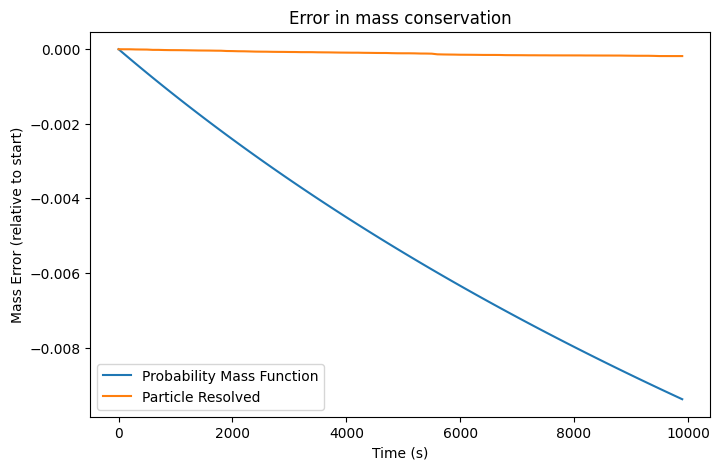

In [13]:
# mass conservation plot

mass_pmf_error = (total_mass_pmf - total_mass_pmf[0]) / total_mass_pmf[0]
mass_resolved_error = (
    total_mass_resolved - total_mass_resolved[0]
) / total_mass_resolved[0]


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time, mass_pmf_error, label="Probability Mass Function")
ax.plot(time, mass_resolved_error, label="Particle Resolved")
# ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Mass Error (relative to start)")
ax.set_title("Error in mass conservation")
ax.legend()
plt.show()

**Plot Number Error**

For the number concentration, we use the PDF distribution as the reference. We calculate the percent error in the number concentration for the PMF and particle-resolved approaches compared to the PDF distribution.

Resolved number final: 6.26e+10, PMF number final: 6.26e+10


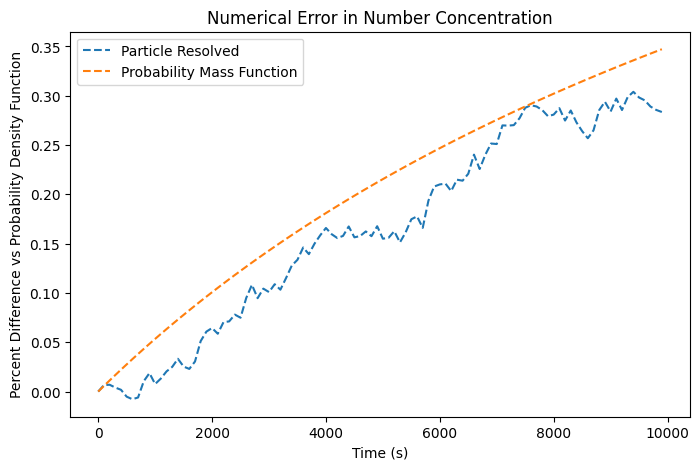

In [14]:
# sum number concentration and plot

total_pmf = np.sum(number_distribution_pmf, axis=1)
total_resolved_non_zero = number_distribution_resolved > 0
total_resolved = np.sum(total_resolved_non_zero, axis=1) / volume

percent_diff_resolved = (
    (total_number_pdf - total_resolved) / total_number_pdf * 100
)
percent_diff_pmf = (total_number_pdf - total_pmf) / total_number_pdf * 100

print(
    f"Resolved number final: {total_resolved[-1]:.2e}, PMF number final: {total_pmf[-1]:.2e}"
)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time, percent_diff_resolved, label="Particle Resolved", linestyle="--")
ax.plot(
    time, percent_diff_pmf, label="Probability Mass Function", linestyle="--"
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Percent Difference vs Probability Density Function")
ax.set_title("Numerical Error in Number Concentration")
ax.legend()
plt.show()

## Conclusion

In this notebook, we compared the PMF, PDF, and particle-resolved approaches for modeling particle distributions and the coagulation process. We found that each method has its strengths and limitations, with the PMF and PDF approaches providing a more continuous representation of the particle distribution, while the particle-resolved approach offers a more detailed view of individual particles.

They all have numerical errors, but the PDF method is the most accurate in terms of mass conservation and number concentration. The PMF method has the largest error in mass concentration. The particle-resolved method has variable error in number concentration.